# 1. Import the libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import tarfile
import requests
from IPython.display import HTML
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import umap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings('ignore')
sklearn.set_config(display='diagram')

# 2. Load the data

In [54]:
if not os.path.exists('Data/games.csv'):
    if not os.path.exists('Data'):
    path = os.path.abspath('.')+'/games.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/LaraN01/CAS_Applied_Data_Science/raw/main/07_deliverables/datasets/games.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    
    # Use the requests library to fetch the raw file
    response = requests.get(url_with_token, headers=headers)
    
    if response.status_code == 200:
        with open(path, 'wb') as f:
            f.write(response.content)
        
        tar = tarfile.open(path, "r:gz")
        tar.extractall()
        tar.close()
    else:
        print(f"Failed to fetch {url_with_token}. Status code: {response.status_code}")

# 3. Prepare the dataset

In [55]:
def games_dataset():
    path = 'data/games.csv'
    games = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
    games_to_drop=['Game Name','Family', 'Sculptor', 'Publishers', 'Designers', 'Artists', 'subtype', 'num_ratings']
    games_clean_drop=games.drop(games_to_drop, axis=1, inplace=True)
    
    #Rating filter
    threshold=0.1  #set the threshold for the games' rating to use
                 #example use: threshold=6, all games with rating minor than 6 will be dropped from the dataframe
    games_clean_rat=games.loc[games['Rating']>threshold]
    games=games_clean_rat
   
    #Year Filter
    threshold=2000  #set the threshold for the games' year of publication to use
                 #example use: threshold=2000, all games published before 2000 will be dropped from the dataframe
    games_clean_year=games.loc[games['Year Published']>threshold]
    games=games_clean_year
    
    #Feature engineering
    games['avg_players'] = (games['Min Players'] + games['Max Players']) / 2
    games['avg_time'] = (games['Play Time Min'] + games['Play Time Max']) / 2
    
    #type conversion
    games['Game ID']=games['Game ID'].astype(float) 
    games['Num Expansions']=games['Num Expansions'].astype(float)    
    
    #Final drop and clean
    games_clean=games.loc[(games['Min Players']>0) & (games['Play Time Min']>0) & 
                          (games['Weight']>0) & (games['Max Players']>0) & 
                          (games['Play Time Max']>0) & (games['bayes_average']>0) ]
        
    averaged=['Min Players','Max Players','Play Time Min', 'Play Time Max']
    games_clean=games_clean.drop(averaged, axis=1)
  
    return games_clean

In [56]:
games=games_dataset()

# 4. General evaluation (shape, info, describe, distribution)

In [57]:
games.shape

(23015, 11)

In [58]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23015 entries, 828 to 376035
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Game ID         23015 non-null  float64
 1   Weight          23015 non-null  float64
 2   Rating          23015 non-null  float64
 3   Min Age         23015 non-null  float64
 4   Num Expansions  23015 non-null  float64
 5   Year Published  23015 non-null  float64
 6   Mechanisms      23015 non-null  object 
 7   Categories      23015 non-null  object 
 8   bayes_average   23015 non-null  float64
 9   avg_players     23015 non-null  float64
 10  avg_time        23015 non-null  float64
dtypes: float64(9), object(2)
memory usage: 2.1+ MB


In [59]:
games.describe()

,Game ID,Weight,Rating,Min Age,Num Expansions,Year Published,bayes_average,avg_players,avg_time
count,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000,23015.000000
mean,182008.587921,2.106770,6.824262,10.127830,1.673604,2014.512231,5.723742,3.877949,68.482294
std,112134.333834,0.816937,0.927440,3.595111,6.932129,5.832428,0.377439,7.435910,164.077767
min,829.000000,1.000000,1.244700,0.000000,0.000000,2001.000000,4.637540,1.000000,1.000000
25%,72986.000000,1.432400,6.224020,8.000000,0.000000,2010.000000,5.523530,2.500000,27.500000
50%,191475.000000,2.000000,6.869770,10.000000,0.000000,2016.000000,5.571010,3.000000,45.000000
75%,271903.000000,2.666700,7.493745,13.000000,1.000000,2019.000000,5.740275,4.000000,75.000000
max,399920.000000,5.000000,9.663330,24.000000,326.000000,2025.000000,8.422860,500.500000,8000.000000


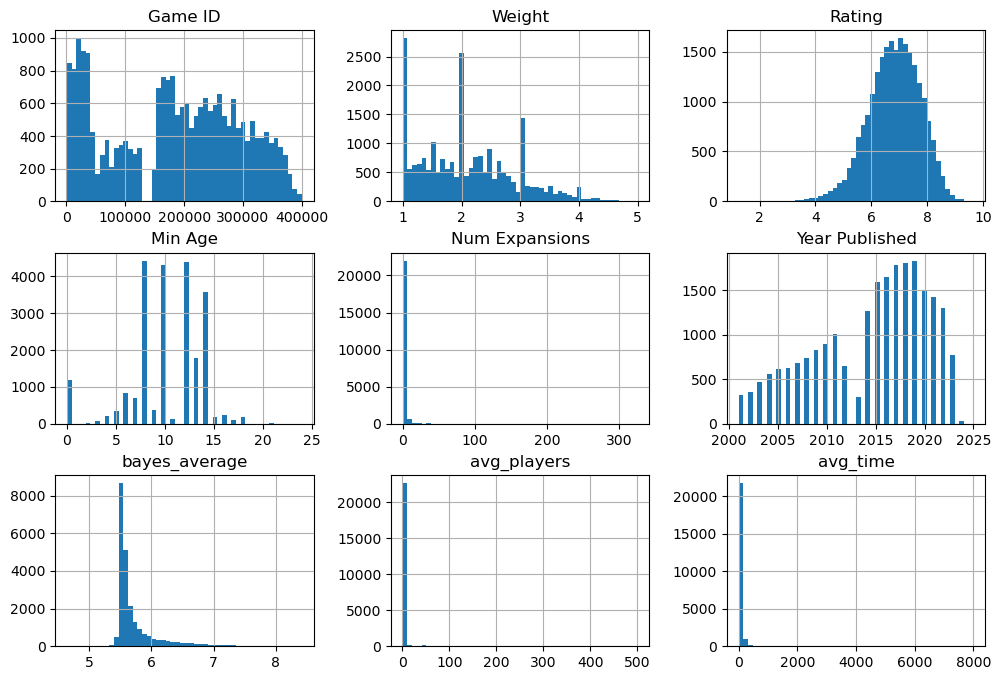

In [60]:
games_num = games.select_dtypes(include=[np.number])
games_num.hist(bins=50, figsize=(12, 8))
plt.show()

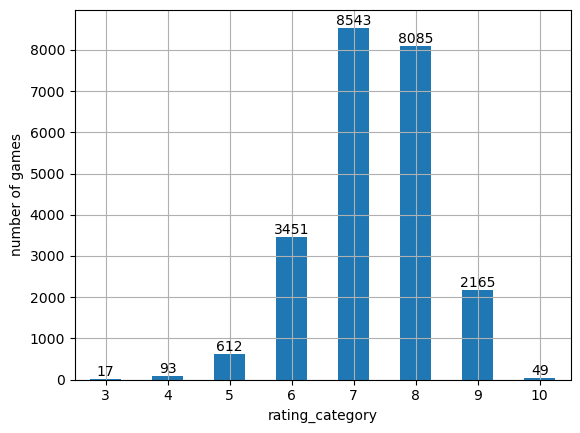

In [61]:
games['rating_cat']=pd.cut(games['Rating'],
                           bins=[0,3,4,5,6,7,8,9,np.inf],
                           labels=[3,4,5,6,7,8,9,10])

category_counts = games['rating_cat'].value_counts().sort_index()
ax = category_counts.plot(kind='bar', rot=0, grid=True)
for i, v in enumerate(category_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.xlabel('rating_category')
plt.ylabel('number of games')
plt.show()

NOTE: Ensure that all the categories have >=2 entries, if not adapt the bins.

This is required for the stratified splitter

# 5. Train set, test set, validation set

## 5.1 Train set, test set

In [62]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state= 42)
for train_index, test_index in splitter.split(games, games['rating_cat']):
    strat_train_set = games.iloc[train_index]
    strat_test_set = games.iloc[test_index]
      
features= ['avg_players', 'avg_time', 'Weight', 'Min Age', 'Num Expansions',
               'Year Published','Categories', 'Mechanisms']
target_feature='Rating'

X_train= strat_train_set[features]
y_train = strat_train_set[target_feature]
X_test= strat_test_set[features]
y_test = strat_test_set[target_feature]

# 6. Feature scaling and transformation 

## 6.1 Custom transformer

In [63]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self,n_clusters=5, gamma=1.0, random_state=None):
        self.n_clusters=n_clusters
        self.gamma=gamma
        self.random_state=random_state
    
    def fit(self, X, y=None, sample_weight=None):
        X=check_array(X)
        self.kmeans_=KMeans(self.n_clusters, random_state=self.random_state, n_init=10)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        check_is_fitted(self)
        X=check_array(X)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

## 6.2 Pipelines

In [64]:
cbrt_pipeline=make_pipeline(FunctionTransformer(np.cbrt, feature_names_out='one-to-one'),
                          StandardScaler())

log_pipeline=make_pipeline(FunctionTransformer(np.log, feature_names_out='one-to-one'),
                          StandardScaler())

cluster_simil=ClusterSimilarity(n_clusters=5, gamma=1, random_state=42)

default_num_pipeline=StandardScaler()

## 6.3 Pre-processing

In [65]:
preprocessing=ColumnTransformer([
    ('weights', cluster_simil, ['Weight']),
    ('expansion',cbrt_pipeline, ['Num Expansions']),
    ('log_feat',log_pipeline, ['avg_players', 'avg_time']),
    ('num_default', default_num_pipeline, ['Min Age','Year Published']),
],
remainder='passthrough')

In [66]:
X_train_preprocessed=preprocessing.fit_transform(X_train)
X_test_preprocessed=preprocessing.transform(X_test)
print('Train set shape=', X_train_preprocessed.shape)
print('Test set shape=', X_test_preprocessed.shape)

Train set shape= (18412, 12)
Test set shape= (4603, 12)


In [67]:
df_X_train_preprocessed=pd.DataFrame(X_train_preprocessed,
                             columns=preprocessing.get_feature_names_out(),
                             index=X_train.index)
df_X_test_preprocessed=pd.DataFrame(X_test_preprocessed,
                             columns=preprocessing.get_feature_names_out(),
                             index=X_test.index)

In [68]:
df_X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18412 entries, 188467 to 300776
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   weights__Cluster 0 similarity  18412 non-null  object
 1   weights__Cluster 1 similarity  18412 non-null  object
 2   weights__Cluster 2 similarity  18412 non-null  object
 3   weights__Cluster 3 similarity  18412 non-null  object
 4   weights__Cluster 4 similarity  18412 non-null  object
 5   expansion__Num Expansions      18412 non-null  object
 6   log_feat__avg_players          18412 non-null  object
 7   log_feat__avg_time             18412 non-null  object
 8   num_default__Min Age           18412 non-null  object
 9   num_default__Year Published    18412 non-null  object
 10  remainder__Categories          18412 non-null  object
 11  remainder__Mechanisms          18412 non-null  object
dtypes: object(12)
memory usage: 1.8+ MB


## 6.4 Categorical variables

In [69]:
object_cols=['remainder__Categories','remainder__Mechanisms']
print('Categorical variables:')
print(object_cols)

Categorical variables:
['remainder__Categories', 'remainder__Mechanisms']


In [70]:
mlb = MultiLabelBinarizer()

mlb_cols_train_list = []
mlb_cols_test_list = []

for column in object_cols:
    categories_list_train = df_X_train_preprocessed[column].apply(eval)
    categories_list_test = df_X_test_preprocessed[column].apply(eval)
    
    mlb_cols_train = pd.DataFrame(mlb.fit_transform(categories_list_train), columns=mlb.classes_, index=df_X_train_preprocessed.index)
    mlb_cols_train_list.append(mlb_cols_train)
    
    mlb_cols_test = pd.DataFrame(mlb.transform(categories_list_test), columns=mlb.classes_, index=df_X_test_preprocessed.index)
    mlb_cols_test_list.append(mlb_cols_test)

X_train_prep = pd.concat([df_X_train_preprocessed.drop(object_cols, axis=1)] + mlb_cols_train_list, axis=1)
X_test_prep = pd.concat([df_X_test_preprocessed.drop(object_cols, axis=1)] + mlb_cols_test_list, axis=1)

X_train_prep = X_train_prep.loc[:,~X_train_prep.columns.duplicated()]
X_test_prep = X_test_prep.loc[:,~X_test_prep.columns.duplicated()]

o = (X_train_prep.dtypes == 'object')
obj_list = list(o[o].index)
X_train_prep[obj_list] = X_train_prep[obj_list].astype(float)
X_test_prep[obj_list] = X_test_prep[obj_list].astype(float)

print('Train set shape=', X_train_prep.shape)
print('Test  set shape=', X_test_prep.shape)
#print(X_train_prep.info())

Train set shape= (18412, 282)
Test  set shape= (4603, 282)


In [71]:
df_X_train_prep=pd.DataFrame(X_train_prep)
df_X_test_prep=pd.DataFrame(X_test_prep)

# 7. Unsupervised learning model

## 7.1 PCA

In [72]:
pca=PCA()
components=pca.fit(X_train_prep)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1
d

112

In [73]:
print(components.explained_variance_ratio_[:d])

[0.16228063 0.09864274 0.09521548 0.07830079 0.05966058 0.02890705
 0.02472953 0.01892185 0.01631099 0.01442693 0.01354393 0.01265271
 0.01140009 0.01083097 0.01010174 0.00938616 0.00902103 0.00834994
 0.00788389 0.00777718 0.00713167 0.00670557 0.00628822 0.00622536
 0.00611878 0.00585305 0.00561395 0.00545612 0.00535113 0.00523138
 0.00513289 0.00501044 0.00488398 0.00469387 0.00462242 0.00430387
 0.00425226 0.00423559 0.00414577 0.00406768 0.00398799 0.0039381
 0.00386001 0.00373321 0.00365959 0.00353374 0.00342869 0.0033952
 0.00329247 0.00325861 0.00318092 0.00304263 0.00300406 0.00290807
 0.00286718 0.0027469  0.00272471 0.00267644 0.00266859 0.00260442
 0.00257514 0.00253237 0.00246867 0.00242513 0.00237028 0.00234383
 0.00231473 0.00227992 0.00212826 0.00207177 0.00200613 0.00197108
 0.00196512 0.00190548 0.00187275 0.00180321 0.00180056 0.00175108
 0.00172407 0.00170198 0.00168383 0.00162546 0.00161077 0.00158431
 0.00152763 0.00149635 0.00144059 0.00141156 0.00138426 0.001357

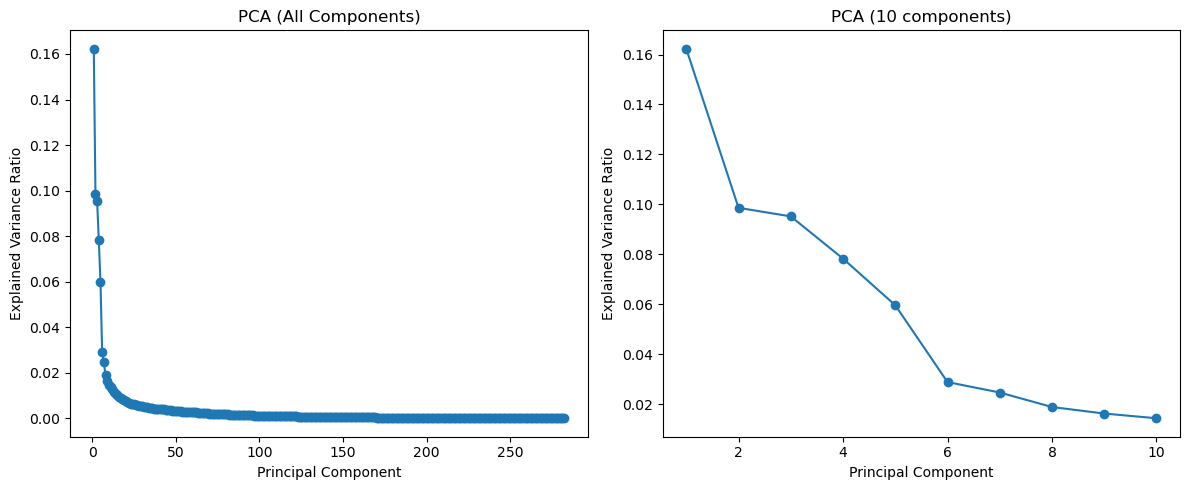

In [74]:
total_components = X_train_prep.shape[1]

pca_all = PCA(n_components=total_components)
pca_all.fit(X_train_prep)

num_components_to_plot = 10
components_chosen = PCA(n_components=num_components_to_plot)
components_chosen.fit(X_train_prep)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(np.arange(1, total_components + 1), pca_all.explained_variance_ratio_, '-o')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA (All Components)')

axes[1].plot(np.arange(1, num_components_to_plot + 1), components_chosen.explained_variance_ratio_, marker='o')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('PCA ({} components)'.format(num_components_to_plot))

plt.tight_layout()
plt.show()

## 7.2 UMAP

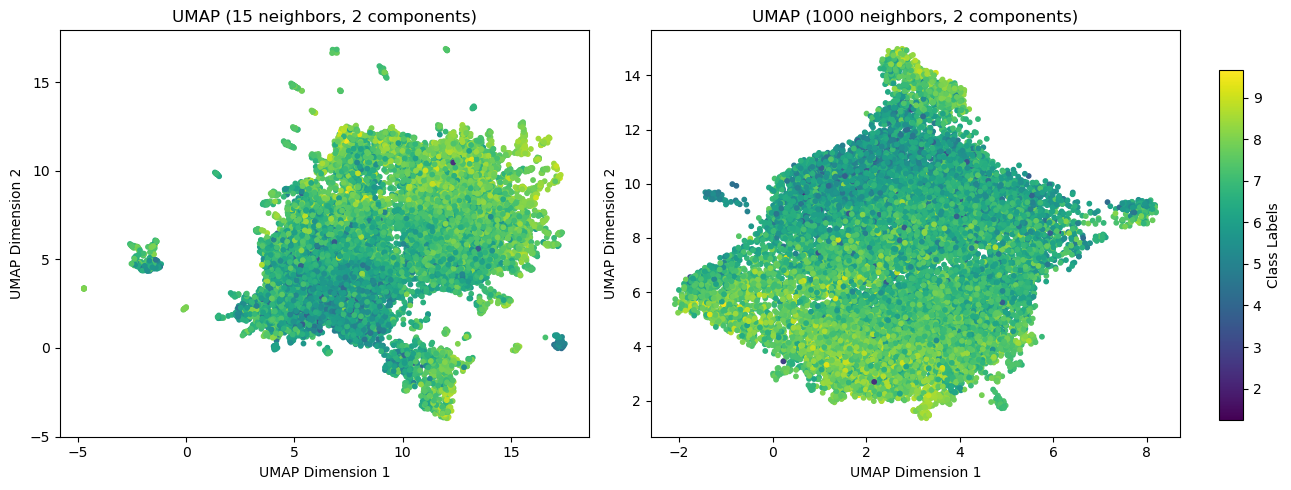

In [75]:
umap_model_10 = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.5)
umap_df_X_train_prep_10 = umap_model_10.fit_transform(df_X_train_prep)

umap_model_1000 = umap.UMAP(n_neighbors=1000, n_components=2, min_dist=0.5)
umap_df_X_train_prep_1000 = umap_model_1000.fit_transform(df_X_train_prep)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter_10 = axes[0].scatter(
    umap_df_X_train_prep_10[:, 0],
    umap_df_X_train_prep_10[:, 1],
    c=y_train,
    s=10,
)
axes[0].set_title('UMAP (15 neighbors, 2 components)')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')

scatter_1000 = axes[1].scatter(
    umap_df_X_train_prep_1000[:, 0],
    umap_df_X_train_prep_1000[:, 1],
    c=y_train,
    s=10,
)
axes[1].set_title('UMAP (1000 neighbors, 2 components)')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')

colorbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
colorbar = fig.colorbar(scatter_1000, cax=colorbar_ax, orientation='vertical', label='Class Labels', pad=0.1)

plt.tight_layout()
plt.show()

## 7.3 Gaussian

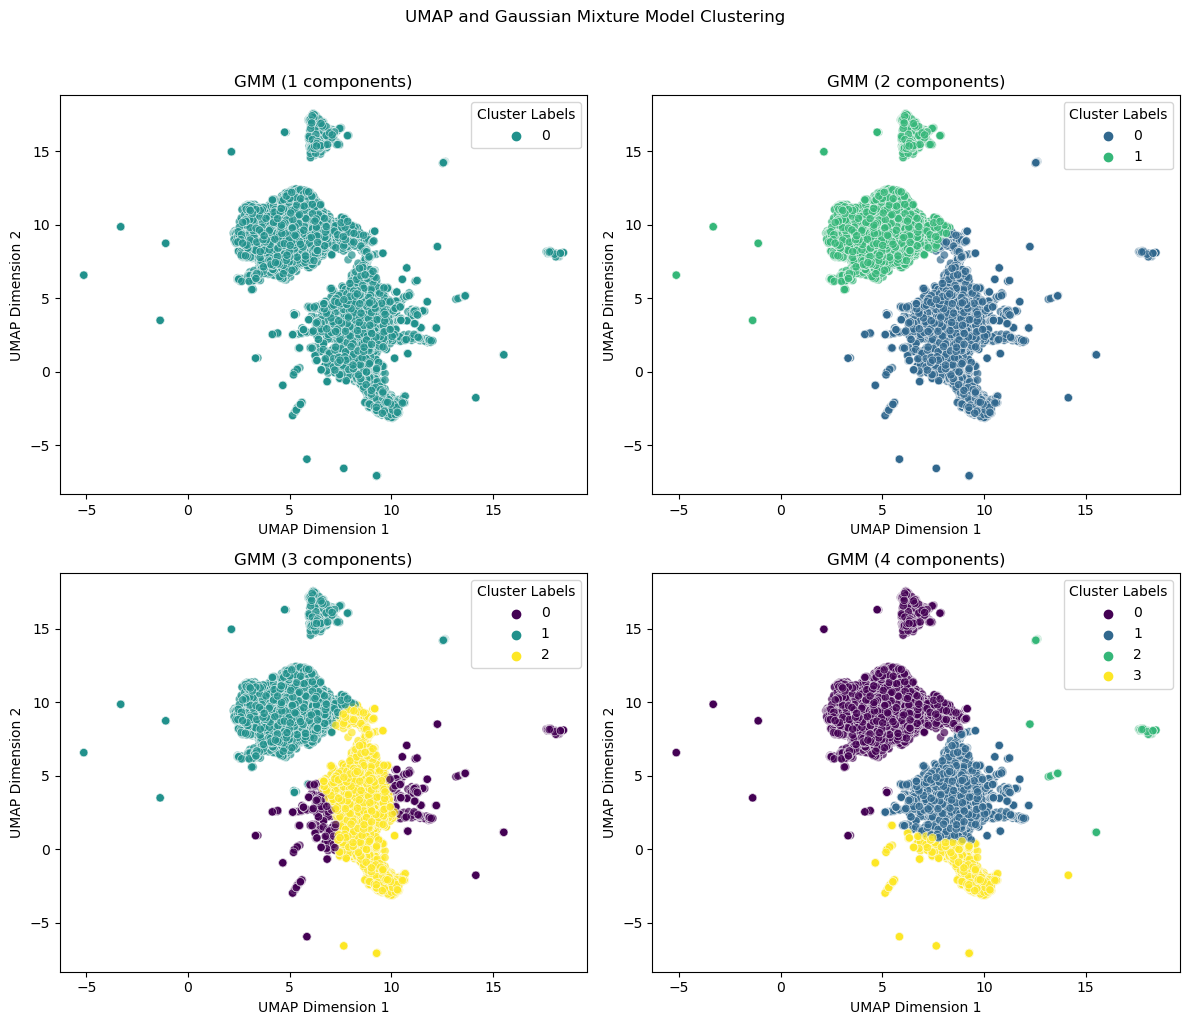

In [76]:
import umap
import seaborn as sns
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

umap_model = umap.UMAP(n_neighbors=15, n_components=2)
umap_result = umap_model.fit_transform(X_train_prep)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for n_components in range(1, 5):
    gm = GaussianMixture(n_components=n_components, covariance_type='full')
    cluster_labels = gm.fit_predict(umap_result)

    df_umap = pd.DataFrame(umap_result, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    df_umap['Cluster Labels'] = cluster_labels

    sns.scatterplot(x='UMAP Dimension 1', y='UMAP Dimension 2', hue='Cluster Labels', data=df_umap, palette='viridis', markers='.', alpha=0.7, ax=axes[n_components - 1])
    axes[n_components - 1].set_title('GMM ({} components)'.format(n_components))

plt.suptitle('UMAP and Gaussian Mixture Model Clustering', y=1.02)
plt.tight_layout()
plt.show()

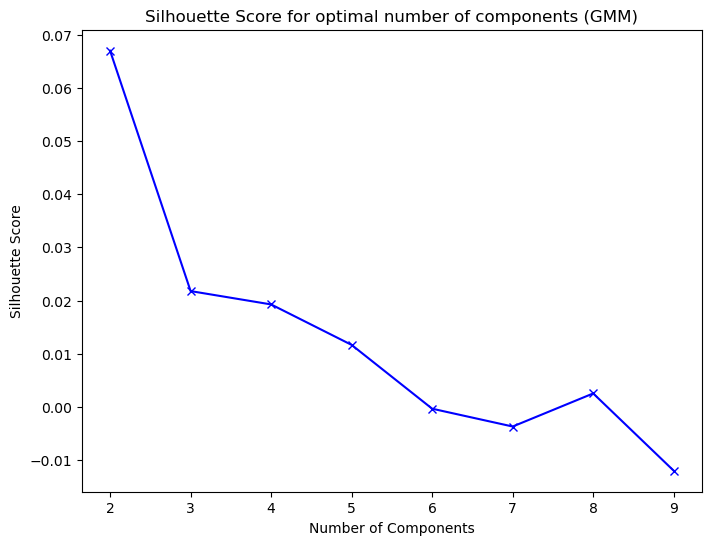

In [77]:
silhouette_scores = []
n_components_range = range(2, 10)

for n_components in n_components_range:
    gmm_model = GaussianMixture(n_components=n_components, covariance_type='full')
    cluster_labels = gmm_model.fit_predict(X_train_prep)
    silhouette_scores.append(silhouette_score(X_train_prep, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, silhouette_scores, 'bx-')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for optimal number of components (GMM)')
plt.show()

Silhouette Score close to 0: no substantial structure has been found / clustering not effective

## 7.3 Final model with UMAP dimensionality reduction

In [78]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2)
umap_df_X_train_prep = umap_model.fit_transform(df_X_train_prep)

xgb_reg = xgb.XGBRegressor()
xgb_cval_preds = cross_val_predict(xgb_reg, umap_df_X_train_prep, y_train, cv=5)

mse = mean_squared_error(y_train, xgb_cval_preds)
rmse = np.sqrt(mse)
print("Cross-validated RMSE is:", rmse)

Cross-validated RMSE is: 0.6689373496871411


## 7.4 Final model combinig UMAP with original features

In [79]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1000)
umap_df_X_train_prep = umap_model.fit_transform(df_X_train_prep)

X_combined = np.hstack([df_X_train_prep, umap_df_X_train_prep])

xgb_reg = xgb.XGBRegressor()

xgb_cval_preds_combined = cross_val_predict(xgb_reg, X_combined, y_train, cv=5)

mse_combined = mean_squared_error(y_train, xgb_cval_preds_combined)
rmse_combined = np.sqrt(mse_combined)
print("Cross-validated RMSE with combined UMAP and original features is:", rmse_combined)


Cross-validated RMSE with combined UMAP and original features is: 0.571170939290686


# 8. Supervised learning model

## 8.1 Simple models

### 8.1.1 Linear regressor

In [80]:
lin_reg=LinearRegression()
lin_reg.fit(X_train_prep, y_train)
games_lin_preds=lin_reg.predict(X_train_prep)
lin_rmse=mean_squared_error(y_train, games_lin_preds, squared=False)

### 8.1.2 Decision tree regressor

In [81]:
tree_reg=DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_prep, y_train)
games_tree_preds=tree_reg.predict(X_train_prep)
tree_rmse=mean_squared_error(y_train, games_tree_preds, squared=False)

### 8.1.3 Output from simple models

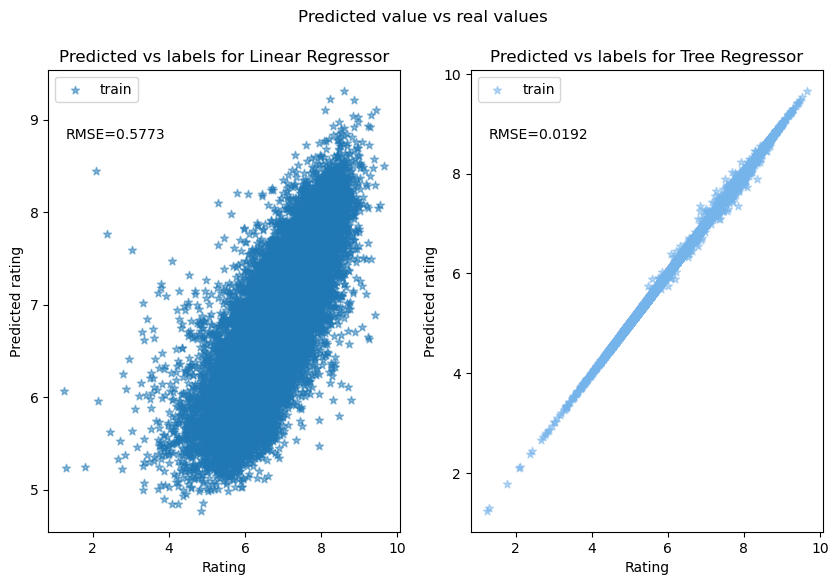

RMSE with Linear regression model is= 0.5773261194929714
RMSE with decision tree regression model is= 0.019198330564148925


In [82]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Predicted value vs real values')
for ax, preds, rmse, color, label in zip(axs, [games_lin_preds, games_tree_preds], [lin_rmse, tree_rmse], 
                                         ['#1f77b4', '#75B3EB'], ['Linear Regressor', 'Tree Regressor']):
    ax.scatter(y_train, preds, c=color, marker='*', label='train', alpha=0.5)
    ax.set_title(f'Predicted vs labels for {label}')
    ax.text(0.05, 0.85, f'RMSE={rmse:.4f}', transform=ax.transAxes)
    ax.set_xlabel('Rating')
    ax.set_ylabel('Predicted rating')
    ax.legend(loc='upper left')
plt.show()

print('RMSE with Linear regression model is=', lin_rmse)
print('RMSE with decision tree regression model is=', tree_rmse)

Simple decision tree overfit the data: the model is not suitable.

## 8.2 Simple models with cross-validation

### 8.2.1 Linear regressor

In [83]:
lin_rmses=-cross_val_score(lin_reg,X_train_prep, y_train,
                           scoring='neg_root_mean_squared_error', cv=5)
lin_cval_preds = cross_val_predict(lin_reg, X_train_prep, y_train, cv=5)

### 8.2.2 Decision Tree

In [84]:
tree_rmses=-cross_val_score(tree_reg,X_train_prep, y_train,
                           scoring='neg_root_mean_squared_error', cv=5)
tree_cval_preds = cross_val_predict(tree_reg, X_train_prep, y_train, cv=5)

### 8.2.3 RandomForest

In [85]:
forest_reg=RandomForestRegressor(random_state=42)
forest_rmses=-cross_val_score(forest_reg, X_train_prep, y_train, 
                             scoring='neg_root_mean_squared_error', cv=5)
forest_cval_preds = cross_val_predict(forest_reg, X_train_prep, y_train, cv=5)

NOTE: 740s running time required

### 8.2.4 Boosted trees

In [86]:
xgb_reg=xgb.XGBRegressor()
xgb_rmses=-cross_val_score(xgb_reg, X_train_prep, y_train, 
                             scoring='neg_root_mean_squared_error', cv=5)
xgb_cval_preds = cross_val_predict(xgb_reg, X_train_prep, y_train, cv=5)

NOTE: 14s running time required

### 8.2.5 Output from simple models with cross-validation

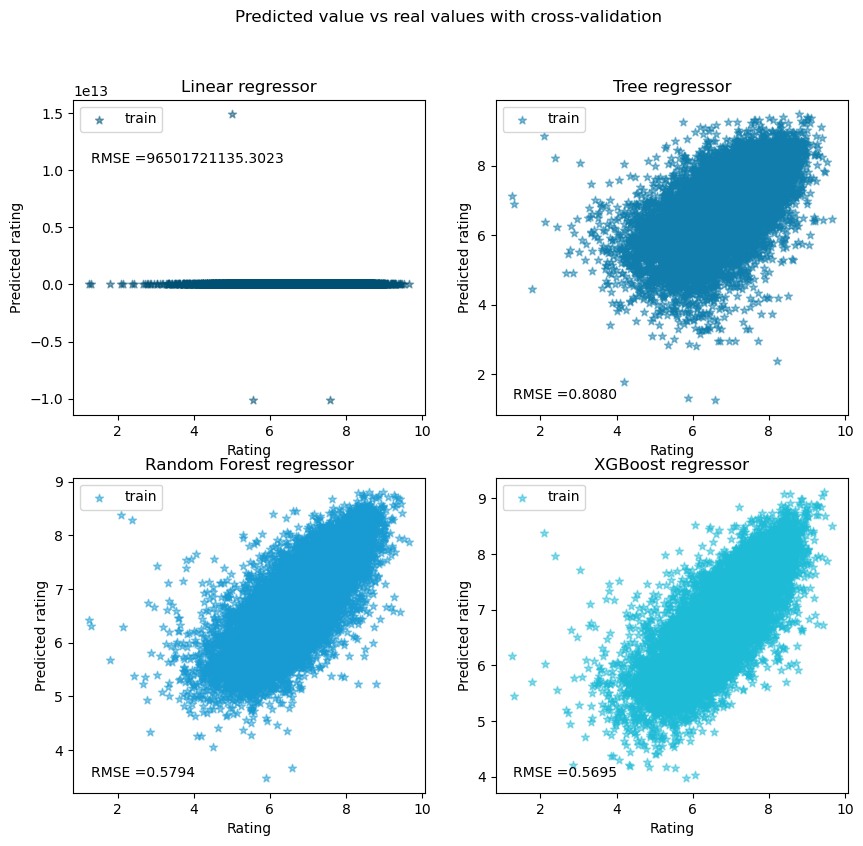

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(10,9))
axs[0, 0].scatter(y_train,lin_cval_preds,c='#005073',marker='*', label='train', alpha=0.5)
axs[0, 0].set_title('Linear regressor')
axs[0, 0].text(0.05, 0.80, f'RMSE ={lin_rmses.mean():.4f}', transform=axs[0, 0].transAxes)
axs[0, 1].scatter(y_train,tree_cval_preds,c='#107dac',marker='*', label='train', alpha=0.5)
axs[0, 1].set_title('Tree regressor')
axs[0, 1].text(0.05, 0.05, f'RMSE ={tree_rmses.mean():.4f}', transform=axs[0, 1].transAxes)
axs[1, 0].scatter(y_train,forest_cval_preds,c='#189ad3',marker='*', label='train', alpha=0.5)
axs[1, 0].set_title('Random Forest regressor')
axs[1, 0].text(0.05, 0.05, f'RMSE ={forest_rmses.mean():.4f}', transform=axs[1, 0].transAxes)
axs[1, 1].scatter(y_train,xgb_cval_preds,c='#1ebbd7',marker='*', label='train', alpha=0.5)
axs[1, 1].set_title('XGBoost regressor')
axs[1, 1].text(0.05, 0.05, f'RMSE ={xgb_rmses.mean():.4f}', transform=axs[1, 1].transAxes)
fig.suptitle('Predicted value vs real values with cross-validation')

for ax in axs.flat:
    ax.set(xlabel='Rating', ylabel='Predicted rating')
    ax.legend(loc='upper left')
#for ax in axs.flat:
#    ax.label_outer()

In [88]:
cval_summary=pd.DataFrame(
    {'Linear regressor': pd.Series(lin_rmses).describe(),
     'Tree regressor': pd.Series(tree_rmses).describe(),
     'Random forest regressor':pd.Series(forest_rmses).describe(),
     'XGBoost regressor':pd.Series(xgb_rmses).describe()}, 
    index=pd.Series(xgb_rmses).describe().index)

cval_summary

,Linear regressor,Tree regressor,Random forest regressor,XGBoost regressor
count,5.000000e+00,5.000000,5.000000,5.000000
mean,9.650172e+10,0.807963,0.579374,0.569479
std,1.321811e+11,0.011517,0.010025,0.009135
min,5.780206e-01,0.797488,0.569429,0.559010
25%,5.803957e-01,0.798494,0.572724,0.563703
50%,5.872402e-01,0.803118,0.577498,0.567143
75%,2.366180e+11,0.819867,0.582103,0.576249
max,2.458906e+11,0.820847,0.595118,0.581291


The linear model works fine without cross-validation while it fails with cross-validation, it is possible that the complexity of the system is already too much to be handled by a simple regression line. The tree regressor overfit the data when used on the training set only, while it doesn't adding complexity through a crossvalidation strategy. Both the ensemble methods: RandomForest and XGBoost improve overall performance, are more robust and less pront to overfitting. 

The chosen model for optimization was XGBoost, that shows better performace metrics, is computationally more efficient and scalable (14s vs 740s), from literature XGBoost can handle imbalanced datasets better thank RandomForest and our dataset could easily become inbalanced when user's tastes change, it is possible to add regularization terms to handle overfitting.

## 8.3 Randomized search on cross-validation

### 8.2.3 Hyperparameter tuning - XGBoost regressor

In [89]:
xgb_reg=xgb.XGBRegressor()
param_dict = [
    {'n_estimators': randint(100, 500),
     'learning_rate': uniform(0.01, 0.2),
     'max_depth': randint(3, 10),
     'subsample': uniform(0.8, 0.2),
     'reg_alpha': uniform(0, 0.5),
     'reg_lambda': uniform(0, 0.5)
    }
]
rnd_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dict, n_iter=10, cv=5, 
                                scoring='neg_root_mean_squared_error', 
                                random_state=42)

rnd_search.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002402AE47150>,
                                         'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000240A61C9710>,
                                         'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000240A6260E50>,
                                         'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000240A61CB350>}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [90]:
cv_results = rnd_search.cv_results_
top_indices = np.argsort(cv_results['mean_test_score'])[-5:]
[print(f"Hyperparameters: {cv_results['params'][idx]}, Score: {cv_results['mean_test_score'][idx]}") for idx in top_indices]

Hyperparameters: {'learning_rate': 0.1323306320976562, 'max_depth': 7, 'n_estimators': 335, 'reg_alpha': 0.011531212520707879, 'reg_lambda': 0.2623873301291946, 'subsample': 0.8799721943430512}, Score: -0.5663416536838595
Hyperparameters: {'learning_rate': 0.021282315805420053, 'max_depth': 6, 'n_estimators': 393, 'reg_alpha': 0.00038938292050716417, 'reg_lambda': 0.49610577964560876, 'subsample': 0.9234963019255433}, Score: -0.5661070501916134
Hyperparameters: {'learning_rate': 0.11934205586865593, 'max_depth': 8, 'n_estimators': 290, 'reg_alpha': 0.42114238729749925, 'reg_lambda': 0.22487706668488283, 'subsample': 0.8790300472003629}, Score: -0.5643184914291981
Hyperparameters: {'learning_rate': 0.0849080237694725, 'max_depth': 7, 'n_estimators': 370, 'reg_alpha': 0.36599697090570255, 'reg_lambda': 0.2993292420985183, 'subsample': 0.8312037280884873}, Score: -0.5593953137353669
Hyperparameters: {'learning_rate': 0.056178765124429805, 'max_depth': 6, 'n_estimators': 466, 'reg_alpha': 

[None, None, None, None, None]

In [91]:
best_params=pd.Series(rnd_search.best_estimator_.get_params())
df_best_params=pd.DataFrame(best_params, index=best_params.index)
df_hyperparameter=df_best_params.dropna()
df_hyperparameter

,0
objective,reg:squarederror
enable_categorical,False
learning_rate,0.056179
max_depth,6
n_estimators,466
reg_alpha,0.341632
reg_lambda,0.304998
subsample,0.966639


Hyperparameter fined tuned for the final model 

In [92]:
df_X_train_prep=pd.DataFrame(X_train_prep)
df_features_importances = pd.Series(rnd_search.best_estimator_.feature_importances_, index= df_X_train_prep.columns).sort_values(ascending=False)

fig = px.bar(x = df_features_importances.index, y = df_features_importances, height=800, labels=dict(y="Importance", x="Features"))
fig.update_layout(title_text='Features importance XGBoost regressor')
fig.update_layout(showlegend=False) 
fig.show()

# 9. Final model 

## 9.1 Model definition and check hyperparameters

In [93]:
final_model=rnd_search.best_estimator_

In [94]:
best_params=pd.Series(final_model.get_params())
final_best_params=pd.DataFrame(best_params, index=best_params.index)
final_hyperparameter=df_best_params.dropna()
final_hyperparameter

,0
objective,reg:squarederror
enable_categorical,False
learning_rate,0.056179
max_depth,6
n_estimators,466
reg_alpha,0.341632
reg_lambda,0.304998
subsample,0.966639


## 9.2 Model validation on test set

In [95]:
train_preds=final_model.predict(X_train_prep)
test_preds=final_model.predict(X_test_prep)
train_rmse=mean_squared_error(y_train, train_preds, squared=False)
test_rmse=mean_squared_error(y_test, test_preds, squared=False)

<function matplotlib.pyplot.show(close=None, block=None)>

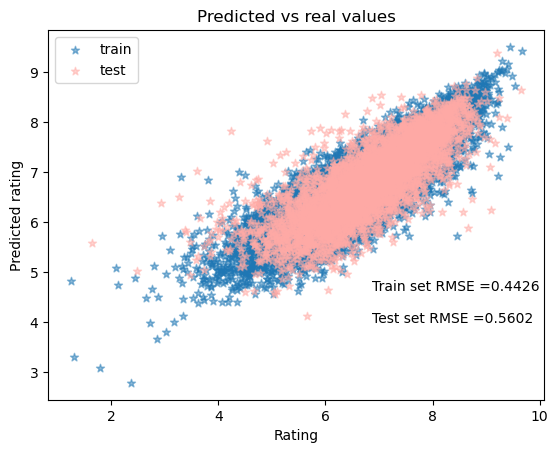

In [96]:
plt.scatter(y_train, train_preds, c='#1f77b4', marker='*', label='train', alpha=0.5)
plt.scatter(y_test, test_preds, c='#ffaaa5', marker='*', label='test', alpha=0.5)
plt.title('Predicted vs real values')
plt.text(-0.5, 0.2, f'Train set RMSE ={train_rmse:.4f}', transform=ax.transAxes)
plt.text(-0.5, 0.1, f'Test set RMSE ={test_rmse:.4f}',transform=ax.transAxes)
plt.xlabel('Rating')
plt.ylabel('Predicted rating')
plt.legend(loc='upper left')
plt.show


From the validation on the test set the model is capable of predict the user's rating for a new games with a precision of +/- 0.56 on the absolute value. 

Further improvement is possible on the model: i.e. allowing a widget selection on the game macrocategory (rpgitem/video game /board game), further tuning of the XGBoost hyperparameter or the exploration of additional hyperparameter could also improve more the model predicting power. 

# 10. Save final model

In [97]:
import joblib

In [98]:
joblib.dump(final_model, "games_rating_model.pkl")

['games_rating_model.pkl']